In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model

In [2]:
class deepRBF(Kern):
    
    def __init__(self,input_dim,variance1=1.,lengthscale=1.,variance2=1.,active_dims=None):
        super(deepRBF, self).__init__(input_dim, active_dims, 'deep_rbf')
        #assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance1 = Param('variance1', variance1)
        self.lengthscale = Param('lengtscale', lengthscale)
        self.variance2 = Param('variance2', variance2)
        #self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.link_parameters(self.variance1, self.lengthscale, self.variance2)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        dist2 = np.square((X-X2.T)/self.lengthscale)
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        return self.variance2*np.power(1 + tmp2,-0.5)
    
    def Kdiag(self,X):
        return self.variance2*np.ones(X.shape[0])
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        dist2 = np.square((X-X2.T)/self.lengthscale)
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1

        dvar2 = np.power(1 + tmp2, -0.5)
        #dl1 = self.power * self.variance * dist2 * self.lengthscale**(-3) * (1 + dist2/2./self.power)**(-self.power-1)
        dvar1 = (-1.)*self.variance2*tmp1*np.power(1+tmp2,-1.5)
        dl = self.variance1*self.variance2*np.exp((-1.)*dist2)*dist2/self.lengthscale*np.power(1+tmp2,-1.5)
        #dp = - self.variance * np.log(1 + dist2/2.) * (1 + dist2/2.)**(-self.power)

        self.variance1.gradient = np.sum(dvar1*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        self.variance2.gradient = np.sum(dvar2*dL_dK)
        #self.lenthscale2.gradient = np.sum(dl2*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance2.gradient = np.sum(dL_dKdiag)
        # here self.lengthscale and self.power have no influence on Kdiag so target[1:] are unchanged
        
    def gradients_X(self,dL_dK,X,X2):
        """derivative of the covariance matrix with respect to X."""
        if X2 is None: X2 = X
        dist2 = np.square((X-X2.T)/self.lengthscale)
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        tmp3 = np.power(1+tmp2,-1.5)

        #dX = -self.variance*self.power * (X-X2.T)/self.lengthscale**2 *  (1 + dist2/2./self.lengthscale)**(-self.power-1)
        dX = (-1.)*self.variance1*self.variance2 * (X-X2.T)/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        return np.sum(dL_dK*dX,1)[:,None]
    
    def gradients_X_diag(self,dL_dKdiag,X):
        # no diagonal gradients
        pass
    


In [3]:
import pods

In [4]:
data = pods.datasets.toy_rbf_1d()

#X1 = np.random.rand(50, 1) * 8    
#X2 = np.random.rand(30, 1) * 5

#build a suitable set of observed variables
#Y1 = np.sin(X1) + np.random.randn(*X1.shape) * 0.05
#Y2 = np.sin(X2) + np.random.randn(*X2.shape) * 0.05 + 2.

#data = pods.datasets.olympic_marathon_men()

#X_data = data['X']
#Y_data = data['Y']

#X_clean = np.vstack((X_data[0:2,:],X_data[3:,:]))
#Y_clean = np.vstack((Y_data[0:2,:],Y_data[3:,:]))

In [5]:
#m1 = GPy.models.GPCoregionalizedRegression(X_list=[X1,X2], Y_list=[Y1,Y2])
#m1.optimize()

m1 = GPy.models.GPRegression(data['X'], data['Y'])
#m1_clean = GPy.models.GPRegression(X_clean, Y_clean)

{'dataplot': [<matplotlib.collections.PathCollection at 0x10e6f58d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x10e6f57b8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x10e6f5e48>]}

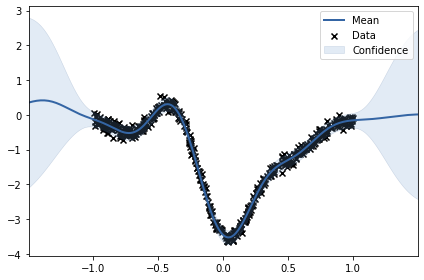

In [6]:
m1.optimize()
m1.plot()

#from matplotlib import pyplot as pb

#slices = GPy.util.multioutput.get_slices([X1,X2])
#m1.plot(fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0})
#m1.plot(fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1},ax=pb.gca())

In [11]:
print(m1)


Name : GP regression
Objective : -387.677496844282
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    1.8055959184570627  |      +ve      |        
  rbf.lengthscale          |   0.26145119947704965  |      +ve      |        
  Gaussian_noise.variance  |  0.010440862144638402  |      +ve      |        


In [15]:
print(m1.kern.lengthscale[0])
print(m1.kern.variance[0])

0.26145119947704965
1.8055959184570627


In [16]:
#kern_test = deepRBF(input_dim=1,variance1=0.1,lengthscale=42,variance2=1.5)
kern_test = deepRBF(input_dim=1)

In [17]:
#m2 = GPy.models.GPCoregionalizedRegression(X_list=[X1,X2], Y_list=[Y1,Y2], kernel=kern_test)
m2 = GPy.models.GPRegression(data['X'], data['Y'], kern_test)
#m2.kern.variance2 = 0.1

In [18]:
m2.optimize()
#m2.optimize_restarts(num_restarts = 5)

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a24472cf8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a2431b128>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a24e0e438>]}

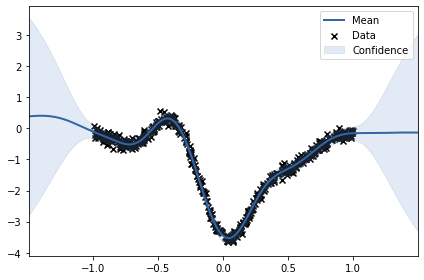

In [19]:
#m2.plot(fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0})
#m2.plot(fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1},ax=pb.gca())
m2.plot()

In [20]:
print(m2)


Name : GP regression
Objective : -384.7198108280783
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  deep_rbf.variance1       |    3.906043231060807  |               |        
  deep_rbf.lengtscale      |  -1.1194555590749196  |               |        
  deep_rbf.variance2       |     8.69362369453644  |               |        
  Gaussian_noise.variance  |  0.01043406871881474  |      +ve      |        


In [22]:
print(m2.kern.variance1[0])
print(m2.kern.variance2[0])
print(m2.kern.lengthscale[0])

3.906043231060807
8.69362369453644
-1.1194555590749196


In [41]:
print(m1)


Name : GP regression
Objective : 606.1991148247475
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [58]:
kernRQ = GPy.kern.RatQuad(input_dim=1)

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a257b2630>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a257b2588>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a257b2dd8>]}

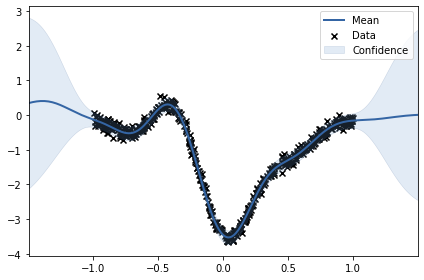

In [60]:
m3 = GPy.models.GPRegression(data['X'], data['Y'], kernRQ)
m3.optimize()
m3.plot()

In [61]:
print(m3)


Name : GP regression
Objective : -387.6919176350534
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  RatQuad.variance         |    1.8629341116489162  |      +ve      |        
  RatQuad.lengthscale      |     2.033579227688356  |      +ve      |        
  RatQuad.power            |     58.21070500751048  |      +ve      |        
  Gaussian_noise.variance  |  0.010437412612277635  |      +ve      |        


In [50]:
import deepgp

In [51]:
hidden = 1
m = deepgp.DeepGP([1,hidden,1],Y=data['Y'], X=data['X'], inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(1,ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)

In [53]:
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=10000)

In [57]:
print(m)


Name : deepgp
Objective : -355.2513241975779
Number of Parameters : 1206
Number of Optimization Parameters : 1206
Updates : True
Parameters:
  deepgp.                           |                 value  |  constraints  |  priors
  obslayer.inducing_inputs          |               (50, 1)  |               |        
  obslayer.rbf.variance             |     10.57589535121904  |      +ve      |        
  obslayer.rbf.lengthscale          |      3.84706892276415  |      +ve      |        
  obslayer.Gaussian_noise.variance  |  0.007891663798599267  |      +ve      |        
  obslayer.Kuu_var                  |                 (50,)  |      +ve      |        
  obslayer.latent_space.mean        |              (500, 1)  |               |        
  obslayer.latent_space.variance    |              (500, 1)  |      +ve      |        
  layer_1.inducing_inputs           |               (50, 1)  |               |        
  layer_1.rbf.variance              |    11.479290774537107  |      +ve    

In [62]:
X_ts = np.linspace(-1.2,1.2,100).reshape(-1,1)

In [70]:
y_pred, vv = m.predict(X_ts)

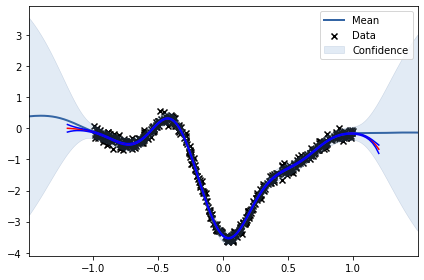

In [71]:
m2.plot()
plt.plot(X_ts,y_pred,'r-')
plt.plot(X_ts,y_pred+2*vv,'b-')
plt.plot(X_ts,y_pred-2*vv,'b-')
#m2.plot()
plt.show()

In [69]:
def rmse(predictions, targets):
    return np.sqrt(((predictions.flatten() - targets.flatten()) ** 2).mean())